In [40]:
from svg.path import parse_path
from xml.dom import minidom
import numpy as np
import matplotlib.pyplot as plt
import math

In [25]:
def centerData(data):
    xMean = np.mean(data[:,0])
    yMean = np.mean(data[:,1])
    return np.array([np.array([x[0]-xMean, x[1]-yMean]) for x in data])

In [27]:
def flipVert(data):
    return np.array([np.array([x[0], -x[1]]) for x in data])

In [95]:
def get_point_at(path, distance, scale, offset):
    pos = path.point(distance)
    pos += offset
    pos *= scale
    return pos.real, pos.imag


def points_from_path(path, density, scale, offset):
    step = int(path.length() * density)
    last_step = step - 1

    if last_step == 0:
        yield get_point_at(path, 0, scale, offset)
        return

    for distance in range(step):
        yield get_point_at(
            path, distance / last_step, scale, offset)


def points_from_doc(doc, density=5, scale=1, offset=0):
    offset = offset[0] + offset[1] * 1j
    points = []
    for element in doc.getElementsByTagName("path"):
        for path in parse_path(element.getAttribute("d")):
            points.extend(points_from_path(
                path, density, scale, offset))

    return points

# limit is the x and -x and y and -y limit at the same time 
def getPointsFromSVG(path, density, limit=None):
    f = open(path, "r")
    string = f.read()
    doc = minidom.parseString(string)
    points = np.array(points_from_doc(doc, density=density, scale=5, offset=(0, 5)))
    doc.unlink()

    # print(string)
    # print(doc)

    # flip points vertically
    points = flipVert(points)

    # centering data at 0
    points = centerData(points)

    # scale data
    if(limit):
        maxX = max([abs(x) for x in points[:,0]])
        maxY = max([abs(x) for x in points[:,1]])
        maxAll = max(maxX, maxY)
        scale = limit/maxAll
        points = np.array([np.array([
            x[0]*scale, 
            x[1]*scale
        ]) for x in points])

    return points

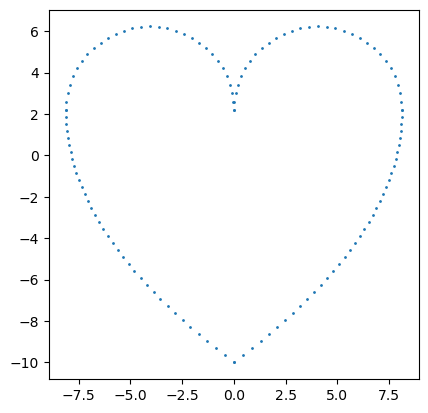

In [96]:
# try code
points = getPointsFromSVG("./svg/heart.svg", .5, 10)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.scatter(points[:,0], points[:,1], s=1);


In [97]:
def closest_node(node, nodes):
    dist = [np.linalg.norm(x - node) for x in nodes]
    return min(dist)

closest_node(np.array([0, -2]), points)

4.173207798448995

# Accuracy between two arrays of points

In [106]:
def accuracy(predicted, target):
    accumulatedAcc = 0
    for i in predicted:
        accumulatedAcc += closest_node(i, target)
    if accumulatedAcc != 0:
        accumulatedAcc = math.log(accumulatedAcc, 10)
    return accumulatedAcc

In [99]:
print(accuracy(points, points))

0.0


## Testing accuracy

5.272782537628834
4.033828523903938


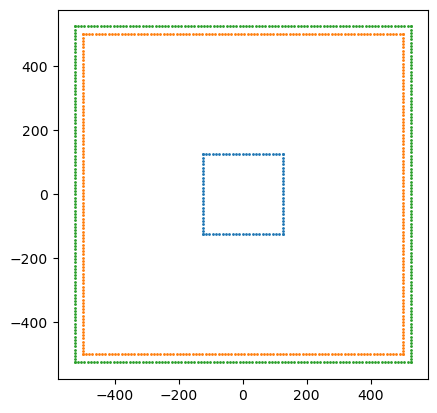

In [107]:
# try code
pointsSmall  = getPointsFromSVG("./svg/squareSmall.svg",  .5)
pointsMedium = getPointsFromSVG("./svg/squareMedium.svg", .5)
pointsLarge  = getPointsFromSVG("./svg/squareLarge.svg",  .5)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.scatter(pointsSmall[:,0], pointsSmall[:,1], s=1);
plt.scatter(pointsMedium[:,0], pointsMedium[:,1], s=1);
plt.scatter(pointsLarge[:,0], pointsLarge[:,1], s=1);

print(accuracy(pointsLarge, pointsSmall))
print(accuracy(pointsLarge, pointsMedium))